In [2]:
from settings import *

##### Set global constants for this experiment

In [3]:
delta_t = 0.5
N = 5
L = 100


##### Load observables

In [4]:
Os = all_observables(m=m)
jump_oper_decay = default_jump_operators(m=m, gammas=gammas)
jump_oper_no_decay = no_decay_jump_operators()

##### Make training data

In [5]:
rho0s = random_rho0s(m=m, L=L)
rhoss, ts = solve_lindblad_rho0s(rho0s=rho0s, delta_t=delta_t, N=N, s=system, jump_opers=jump_oper_decay)
training_data = mk_training_data(rhoss=rhoss, Os=Os)

random_rho0s: setting seed=53755


##### Create a qubit layout and a parametrized circuit on those qubits

In [6]:
qubits = TriangularLayoutAB(m=m, distance=0.9)
circuit = HEA_fac(qubits, depth=10, repeats=1)

<Axes: title={'center': 'Qubit layout'}>

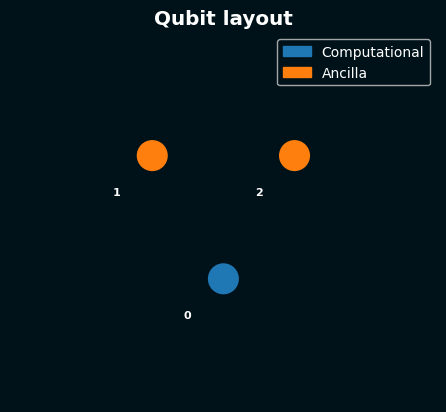

In [7]:
qubits.show_layout()

In [8]:
# optionally load already optimized theta

# theta_opt = np.load("ham_theta_opt.npy")

##### Optimize the parameters

In [9]:
theta_opt, errors, thetas = optimize(
    circuit=circuit,
    training_data=training_data,
    n_grad=10,
    max_count=100,
)

# optionally, save the results of the optimization process

theta_opt = np.save("both_theta_opt.npy", theta_opt)
thetas = np.save("both_thetas.npy", thetas)
errors = np.save("both_errors.npy", errors)

optimizer (optimization indices): setting seed=21194


C:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_channel_approx\optimizer.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[i] = error


-----
        Grad calculation time: 
        56.19169878959656 
        Armijo calculation time: 
        5.201189041137695 
        Total grad descend time: 
        1:1.39


In [10]:
theta_opt = np.load("both_theta_opt.npy")
thetas = np.load("both_thetas.npy")
errors = np.load("both_errors.npy")

Text(0, 0.5, 'error')

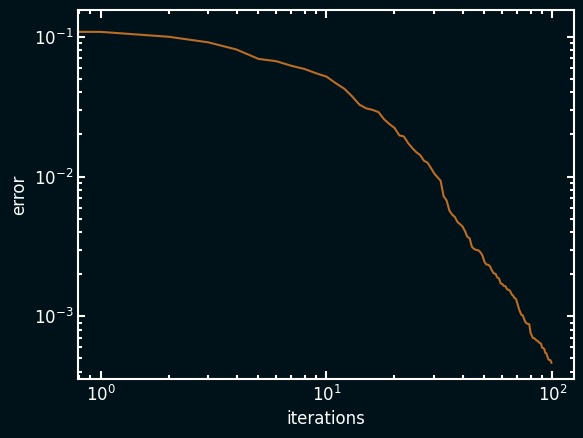

In [11]:
plt.loglog(errors)
plt.xlabel("iterations")
plt.ylabel("error")

##### Plot approximated solution compared to reference solution

In [12]:
n_time_steps = 20

rho0 = rho_rand_haar(m=m, seed=42)

Os_comp = [O.full() for O in create_observables_comp_basis(m=m)]

In [13]:
# calculate reference solution

rhos_ref, ts = solve_lindblad_rho0(rho0, 
                                delta_t=delta_t, 
                                N=n_time_steps, 
                                s=system, 
                                jump_opers=jump_oper_decay,
                                )
Ess_ref = measure_rhos([r.full() for r in rhos_ref], Os_comp)

# calculate approximated solution

evolver = evolver_fac(circuit, theta_opt)
rhos_approx = evolver(n=n_time_steps, rho=rho0.full())
Ess_approx = measure_rhos(rhos_approx, Os_comp)

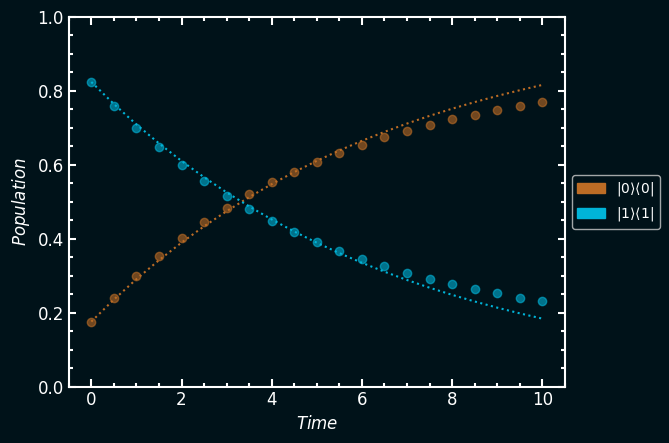

In [16]:
plot_ref(ts, Ess_ref)
plot_approx(ts, Ess_approx)

plt.ylabel("$Population$")
plt.xlabel("$Time$")
plt.ylim(0, 1)
plt.gca().legend(handles=legend_comp(m), loc="center left", bbox_to_anchor=(1, 0.5))